# thal2 1:2 Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 1:2

In [11]:
het_coeffs = [1,100]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (1,2)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 12 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


### Plot 1par eps

In [13]:
etup = (.001,.2,100)

In [14]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=.027,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [15]:


# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-.028,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-0.04,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# # for i in range(4):
# #     draw_quick_plot_f(axs[i],data_b1_list,a)

<Axes: >

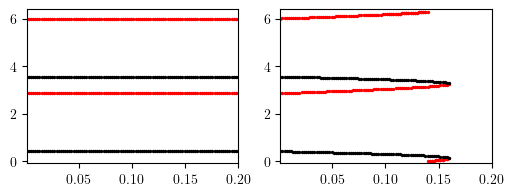

In [16]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=.024,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

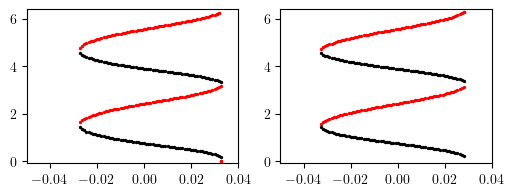

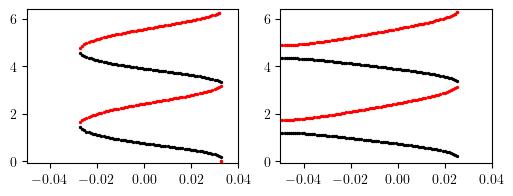

In [17]:
dtup = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a11)

## EPS VARY

In [18]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [19]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [20]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.029

#### Branches eps stable

In [21]:
b=.029
kw_b['recompute'] = False
kw_b['b'] = b

In [22]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.03,eps_final=0,deps=-.005),
            dict(phi0=0,eps_init=0.029,eps_final=0.2,deps=.005)]

In [23]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [24]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [25]:
kw_b['recompute'] = False
kw_b['b'] = b

In [26]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [27]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3
phase_diffs_u_init=3_nm=12_b=0.029_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=3_nm=12_b=0.029_ei=0.05_ef=0_de=-2.txt


In [28]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
           ]

In [29]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=0.029_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.029_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=0.029_ei=0.049_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.029_ei=0.049_ef=0.2_de=0.005.txt


In [30]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

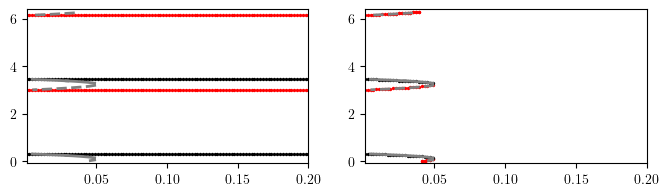

In [31]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [32]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.05 6.142949924463943
phi init 6.142949924463943
Y [-1.08292589e-01  2.26235925e-01  9.52616652e-02  4.05379648e-01 -2.14076201e-01  5.11916061e-01  9.14887984e-02  4.58650751e-03  6.27448102e+00]
mkdir ./data/thal2_12_b0=0.029/
* Loading LC data...
self.T 6.274481086045209
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0017162073514004536
es_min,phi0 0.0495 6.142949924463943
phi init 6.142949924463943
Y [-1.08279318e-01  2.26609868e-01  9.52482933e-02  4.04948403e-01 -2.25508548e-01  5.28008275e-01  9.16162693e-02  1.17656948e-03  6.27447305e+00]
mkdir ./data/thal2_12_b1=0.029/
* Loading LC data...
self.T 6.274473112224061
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002050119033183421
es_min,phi0 0.049 6.142949924463943
phi init 6.142949924463943
Y [-1.08299466e-01  2.32826547e-01  9.52571745e-02  3.97662189e-01 -2.46491278e-01  5.54229613e-01  9.17721606e-02  9.65733625e-05  6.27447005e+00]
mkdir ./data

In [33]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.027

#### Sim

In [34]:
# a=a11;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [35]:
# # show original system
# a=a11;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [36]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [37]:
b=.027
kw_b['recompute'] = False
kw_b['b'] = b

In [38]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=0,eps_init=0.049,eps_final=0.2,deps=.005)]

In [39]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [40]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [41]:
kw_b['recompute'] = False
kw_b['b'] = b

In [42]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [43]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3
phase_diffs_u_init=3_nm=12_b=0.027_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=3_nm=12_b=0.027_ei=0.05_ef=0_de=-2.txt


In [44]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
           ]

In [45]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=0.027_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.027_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=0.027_ei=0.049_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.027_ei=0.049_ef=0.2_de=0.005.txt


In [46]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

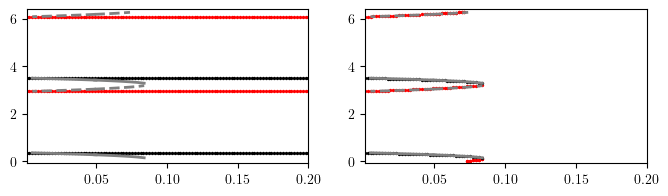

In [47]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [48]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08399999999999999 0.1393234147493816
phi init 0.1393234147493816
Y [-1.08840089e-01  2.27331243e-01  9.62765114e-02  4.03787820e-01 -2.37977688e-01  5.44619312e-01  8.97487677e-02  2.59810159e-04  6.26873600e+00]
mkdir ./data/thal2_12_b0=0.027/
* Loading LC data...
self.T 6.268736062798238
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004216185860762717
es_min,phi0 0.08349999999999999 0.1393234147493816
phi init 0.1393234147493816
Y [-1.08829032e-01  2.29883478e-01  9.62683836e-02  4.00795358e-01 -2.49544599e-01  5.58203355e-01  8.98732810e-02  6.83786057e-05  6.26868132e+00]
mkdir ./data/thal2_12_b1=0.027/
* Loading LC data...
self.T 6.2686813857586685
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004569027735997927
es_min,phi0 0.08299999999999999 0.1393234147493816
phi init 0.1393234147493816
Y [-1.08820096e-01  2.29468012e-01  9.62477711e-02  4.01286868e-01 -2.54813979e-01  5.64014111e-01  8.99692029e-

In [49]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.025

#### Branches eps stable

In [50]:
b=.025
kw_b['recompute'] = False
kw_b['b'] = b

In [51]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=0,eps_init=0.049,eps_final=0.2,deps=.005)]

In [52]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [53]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [54]:
kw_b['recompute'] = False
kw_b['b'] = b

In [55]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [56]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3
phase_diffs_u_init=3_nm=12_b=0.025_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=3_nm=12_b=0.025_ei=0.05_ef=0_de=-2.txt


In [57]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
           ]

In [58]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=0.025_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.025_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=0.025_ei=0.049_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.025_ei=0.049_ef=0.2_de=0.005.txt


In [59]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

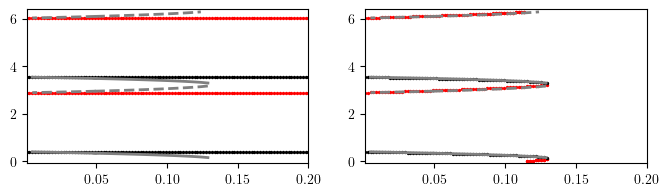

In [60]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [61]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12899999999999995 0.1479081248048848
phi init 0.1479081248048848
Y [-1.09554447e-01  2.30103418e-01  9.76765609e-02  4.00125708e-01 -2.55782742e-01  5.65640041e-01  8.75471573e-02  3.55663292e-05  6.26155303e+00]
mkdir ./data/thal2_12_b0=0.025/
* Loading LC data...
self.T 6.261553091496406
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0077901437982530915
es_min,phi0 0.12849999999999995 0.1479081248048848
phi init 0.1479081248048848
Y [-1.09585402e-01  2.33209803e-01  9.76672128e-02  3.96451774e-01 -2.66138140e-01  5.76196346e-01  8.76676741e-02  1.52909068e-05  6.26144249e+00]
mkdir ./data/thal2_12_b1=0.025/
* Loading LC data...
self.T 6.261442548290631
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.008191668350845064
es_min,phi0 0.12799999999999995 0.1479081248048848
phi init 0.1479081248048848
Y [-1.09579728e-01  2.33221678e-01  9.76449932e-02  3.96439024e-01 -2.70489139e-01  5.80395335e-01  8.77622137e-

In [62]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.023

#### Branches eps stable

In [63]:
b=.023
kw_b['recompute'] = False
kw_b['b'] = b

In [64]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=0,eps_init=0.049,eps_final=0.2,deps=.005)]

In [65]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [66]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [67]:
kw_b['recompute'] = False
kw_b['b'] = b

In [68]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [69]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3
phase_diffs_u_init=3_nm=12_b=0.023_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=3_nm=12_b=0.023_ei=0.05_ef=0_de=-2.txt


In [70]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
           ]

In [71]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=0.023_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.023_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=0.023_ei=0.049_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=0.023_ei=0.049_ef=0.2_de=0.005.txt


In [72]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

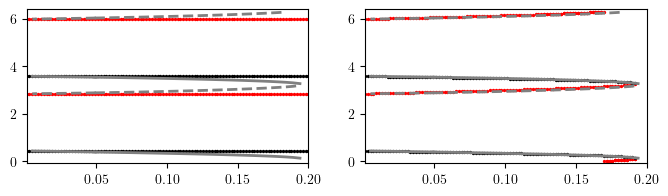

In [73]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [74]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.19399999999999995 0.12416488727774588
phi init 0.12416488727774588
Y [-1.10567796e-01  2.33589766e-01  9.98746507e-02  3.95468535e-01 -2.23246736e-01  5.26922884e-01  8.36714568e-02  1.51666092e-03  6.25470401e+00]
mkdir ./data/thal2_12_b0=0.023/
* Loading LC data...
self.T 6.254704011055279
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0070105987586685774
es_min,phi0 0.19349999999999995 0.12416488727774588
phi init 0.12416488727774588
Y [-1.10528318e-01  2.27669724e-01  9.98302041e-02  4.02493230e-01 -2.18535243e-01  5.20579296e-01  8.37868340e-02  2.66531837e-03  6.25445018e+00]
mkdir ./data/thal2_12_b1=0.023/
* Loading LC data...
self.T 6.254450175556276
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.007856068328122235
es_min,phi0 0.19299999999999995 0.12416488727774588
phi init 0.12416488727774588
Y [-1.10542366e-01  2.26040196e-01  9.98020762e-02  4.04416053e-01 -2.21513625e-01  5.24785789e-01  8.3917

In [75]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.026

#### Branches eps stable

In [76]:
b=-.026
kw_b['recompute'] = False
kw_b['b'] = b

In [77]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.005)]

In [78]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [79]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [80]:
kw_b['recompute'] = False
kw_b['b'] = b

In [81]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [82]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.026_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.026_ei=0.05_ef=0_de=-2.txt


In [83]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
           ]

In [84]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.026_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.026_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=-0.026_ei=0.049_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.026_ei=0.049_ef=0.2_de=0.005.txt


In [85]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

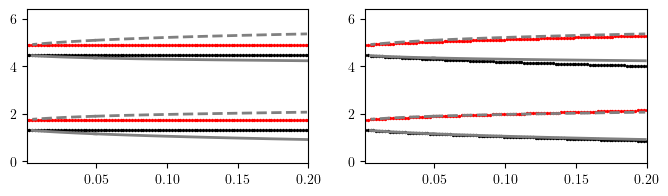

In [86]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [87]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.028

#### Sim

In [88]:
# a=a11;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [89]:
# # show original system
# a=a11;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [90]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [91]:
b=-.028
kw_b['recompute'] = False
kw_b['b'] = b

In [92]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.005)]

In [93]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [94]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [95]:
kw_b['recompute'] = False
kw_b['b'] = b

In [96]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [97]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.028_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.028_ei=0.05_ef=0_de=-2.txt


In [98]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.005),
           ]

In [99]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.028_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.028_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=-0.028_ei=0.049_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.028_ei=0.049_ef=0.2_de=0.005.txt


In [100]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

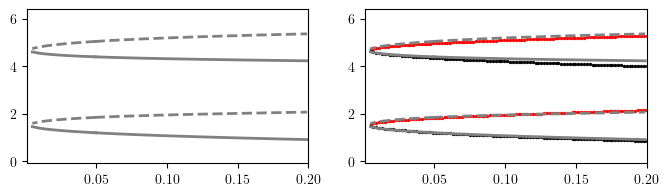

In [101]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [102]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.005000000000000025 1.4496420837904367
phi init 1.4496420837904367
Y [-1.07945452e-01  2.25031808e-01  9.29218301e-02  4.06710685e-01 -5.75231440e-01  5.54296148e-01  9.96153676e-02  1.20094759e-03  6.26994816e+00]
mkdir ./data/thal2_12_b0=-0.028/
* Loading LC data...
self.T 6.26994793226424
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00016134538831991428
es_min,phi0 0.005500000000000026 1.4496420837904367
phi init 1.4496420837904367
Y [-1.08001114e-01  2.24579741e-01  9.28310112e-02  4.07182788e-01 -5.74211020e-01  5.56035536e-01  9.96213681e-02  1.16197471e-03  6.26865815e+00]
mkdir ./data/thal2_12_b1=-0.028/
* Loading LC data...
self.T 6.268657983857689
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00020100870194833726
es_min,phi0 0.006000000000000025 1.4496420837904367
phi init 1.4496420837904367
Y [-1.08033852e-01  2.31145259e-01  9.27680260e-02  3.99446720e-01 -5.74323064e-01  5.55819741e-01  9.961

In [103]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.04

#### Branches eps stable

In [104]:
b=-.04
kw_b['recompute'] = False
kw_b['b'] = b

In [105]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.08,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.079,eps_final=0.2,deps=.01)]

In [106]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [107]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [108]:
kw_b['recompute'] = False
kw_b['b'] = b

In [109]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [110]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.3,eps_init=0.08,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2.3
phase_diffs_u_init=2.3_nm=12_b=-0.04_ei=0.08_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.3_nm=12_b=-0.04_ei=0.08_ef=0_de=-2.txt


In [111]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.08,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.079,eps_final=0.2,deps=.01),
           ]

In [112]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.04_ei=0.08_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.04_ei=0.08_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=-0.04_ei=0.079_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.04_ei=0.079_ef=0.2_de=0.01.txt


In [113]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

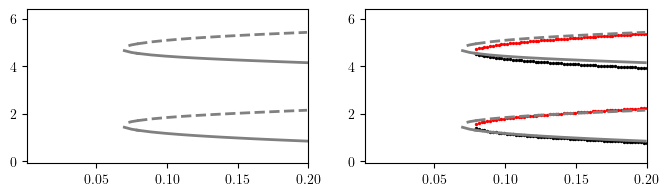

In [114]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [115]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06999999999999999 1.4239280276955197
phi init 1.4239280276955197
Y [-1.13996270e-01  2.27922699e-01  8.21918277e-02  3.96053483e-01 -5.82948343e-01  5.31225932e-01  9.77747399e-02  1.78526111e-03  6.10684159e+00]
mkdir ./data/thal2_12_b0=-0.04/
* Loading LC data...
self.T 6.106841531489737
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0028414786135191787
es_min,phi0 0.0705 1.4239280276955197
phi init 1.4239280276955197
Y [-1.14056260e-01  2.23093713e-01  8.21332640e-02  4.01907492e-01 -5.80897697e-01  5.35039298e-01  9.78861834e-02  1.67321221e-03  6.10602629e+00]
mkdir ./data/thal2_12_b1=-0.04/
* Loading LC data...
self.T 6.1060262682545945
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0032892428382554407
es_min,phi0 0.071 1.4239280276955197
phi init 1.4239280276955197
Y [-1.14092387e-01  2.30234021e-01  8.21162542e-02  3.93130838e-01 -5.81097259e-01  5.35188688e-01  9.79497996e-02  1.67031518e-03  6.105

In [116]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.06

#### Branches eps stable

In [117]:
b=-.06
kw_b['recompute'] = False
kw_b['b'] = b

In [118]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.149,eps_final=0.2,deps=.01)]

In [119]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [120]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [121]:
kw_b['recompute'] = False
kw_b['b'] = b

In [122]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [123]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.3,eps_init=0.15,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2.3
phase_diffs_u_init=2.3_nm=12_b=-0.06_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.3_nm=12_b=-0.06_ei=0.15_ef=0_de=-2.txt


In [124]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.149,eps_final=0.2,deps=.01),
           ]

In [125]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.06_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.06_ei=0.15_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=-0.06_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.06_ei=0.149_ef=0.2_de=0.01.txt


In [126]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

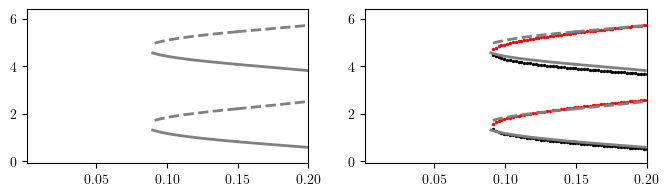

In [127]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [128]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08999999999999994 1.3050696460793043
phi init 1.3050696460793043
Y [-1.15551458e-01  2.27861294e-01  7.99023982e-02  3.94185511e-01 -5.72238372e-01  5.50085902e-01  9.82735813e-02  1.27911844e-03  6.06615471e+00]
mkdir ./data/thal2_12_b0=-0.06/
* Loading LC data...
self.T 6.066154713217186
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.009535118435568871
es_min,phi0 0.09049999999999994 1.3050696460793043
phi init 1.3050696460793043
Y [-1.15575826e-01  2.23784834e-01  7.98919809e-02  3.99206258e-01 -5.70375267e-01  5.53027662e-01  9.83500624e-02  1.21027918e-03  6.06574008e+00]
mkdir ./data/thal2_12_b1=-0.06/
* Loading LC data...
self.T 6.065740049763059
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01010628888696719
es_min,phi0 0.09099999999999994 1.3050696460793043
phi init 1.3050696460793043
Y [-1.15580176e-01  2.26771003e-01  7.99059342e-02  3.95497781e-01 -5.69926954e-01  5.54069278e-01  9.84129730e-02

In [129]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.08

#### Branches eps stable

In [130]:
b=-.08
kw_b['recompute'] = False
kw_b['b'] = b

In [131]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.149,eps_final=0.2,deps=.01)]

In [132]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [133]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [134]:
kw_b['recompute'] = False
kw_b['b'] = b

In [135]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [136]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.3,eps_init=0.15,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2.3
phase_diffs_u_init=2.3_nm=12_b=-0.08_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.3_nm=12_b=-0.08_ei=0.15_ef=0_de=-2.txt


In [137]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.149,eps_final=0.2,deps=.01),
           ]

In [138]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.08_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.08_ei=0.15_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=-0.08_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.08_ei=0.149_ef=0.2_de=0.01.txt


In [139]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

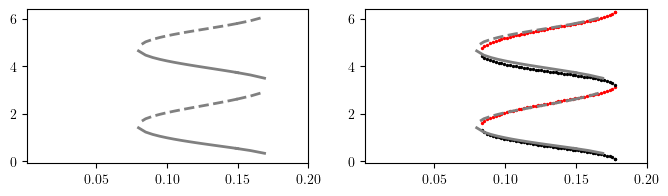

In [140]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [141]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07999999999999993 1.4022993869108813
phi init 1.4022993869108813
Y [-1.14881496e-01  2.29607533e-01  8.07883082e-02  3.92885801e-01 -5.82279385e-01  5.31540546e-01  9.76146317e-02  1.77335287e-03  6.08387866e+00]
mkdir ./data/thal2_12_b0=-0.08/
* Loading LC data...
self.T 6.083878629593112
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004108710612273641
es_min,phi0 0.08049999999999993 1.4022993869108813
phi init 1.4022993869108813
Y [-1.14865364e-01  2.28005601e-01  8.08386940e-02  3.94865929e-01 -5.78628657e-01  5.38874372e-01  9.79272354e-02  1.56504304e-03  6.08406375e+00]
mkdir ./data/thal2_12_b1=-0.08/
* Loading LC data...
self.T 6.08406373372907
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.005487102676290819
es_min,phi0 0.08099999999999993 1.4022993869108813
phi init 1.4022993869108813
Y [-1.14875323e-01  2.23962614e-01  8.08757030e-02  3.99839453e-01 -5.75146947e-01  5.45263081e-01  9.81567961e-02

#### Monodromys max

In [142]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.169 0.32838736490225084
phi init 0.32838736490225084
Y [-1.11036365e-01  2.32163608e-01  9.67576987e-02  3.96167352e-01 -4.02278142e-01  6.55964745e-01  9.03765761e-02  1.65843787e-05  6.22211014e+00]
mkdir ./data/thal2_12_b0=-0.08/
* Loading LC data...
self.T 6.083878629593112
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004108710612273641
es_min,phi0 0.1685 0.32838736490225084
phi init 0.32838736490225084
Y [-1.11088253e-01  2.25579440e-01  9.65676217e-02  4.03929432e-01 -4.01942651e-01  6.55877673e-01  9.05227828e-02  1.66601548e-05  6.22019393e+00]
mkdir ./data/thal2_12_b1=-0.08/
* Loading LC data...
self.T 6.08406373372907
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.005487102676290819
es_min,phi0 0.168 0.32838736490225084
phi init 0.32838736490225084
Y [-1.11140488e-01  2.25416647e-01  9.64048185e-02  4.04050645e-01 -4.04417621e-01  6.56423253e-01  9.07044554e-02  1.72401270e-05  6.21829606e+00]
m

In [143]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.1

#### Branches eps stable

In [144]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [145]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.12,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.119,eps_final=0.2,deps=.01)]

In [146]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [147]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [148]:
kw_b['recompute'] = False
kw_b['b'] = b

In [149]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [150]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.3,eps_init=0.12,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2.3
phase_diffs_u_init=2.3_nm=12_b=-0.1_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.3_nm=12_b=-0.1_ei=0.12_ef=0_de=-2.txt


In [151]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.12,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.119,eps_final=0.2,deps=.01),
           ]

In [152]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=12_b=-0.1_ei=0.12_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.1_ei=0.12_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=12_b=-0.1_ei=0.119_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=12_b=-0.1_ei=0.119_ef=0.2_de=0.01.txt


In [153]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

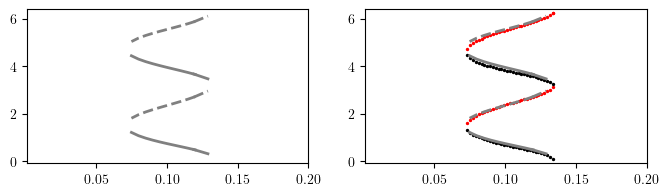

In [154]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [155]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07499999999999996 1.207592749431738
phi init 1.207592749431738
Y [-1.13984368e-01  2.26200821e-01  8.27237870e-02  3.98211060e-01 -5.57488624e-01  5.75906892e-01  9.92217013e-02  7.67373812e-04  6.10833454e+00]
mkdir ./data/thal2_12_b0=-0.1/
* Loading LC data...
self.T 6.108334539357211
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.012470891891930203
es_min,phi0 0.07549999999999996 1.207592749431738
phi init 1.207592749431738
Y [-1.13969722e-01  2.27356977e-01  8.28160630e-02  3.96822025e-01 -5.55606564e-01  5.78715332e-01  9.92824204e-02  7.21937326e-04  6.10879559e+00]
mkdir ./data/thal2_12_b1=-0.1/
* Loading LC data...
self.T 6.108795587791541
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01339684382797624
es_min,phi0 0.07599999999999996 1.207592749431738
phi init 1.207592749431738
Y [-1.13956426e-01  2.27870785e-01  8.29060899e-02  3.96218155e-01 -5.53705528e-01  5.81443575e-01  9.93326830e-02  6.7953

#### Monodromys max

In [156]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.129 0.3092863937901509
phi init 0.3092863937901509
Y [-1.10099432e-01  2.33018410e-01  9.63135947e-02  3.95962835e-01 -3.94195347e-01  6.53901828e-01  9.12023238e-02  1.45677825e-05  6.24063929e+00]
mkdir ./data/thal2_12_b0=-0.1/
* Loading LC data...
self.T 6.108334539357211
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.012470891891930203
es_min,phi0 0.1285 0.3092863937901509
phi init 0.3092863937901509
Y [-1.10120180e-01  2.28645318e-01  9.61024078e-02  4.01065288e-01 -3.96884569e-01  6.54668050e-01  9.14409802e-02  1.51107291e-05  6.23833266e+00]
mkdir ./data/thal2_12_b1=-0.1/
* Loading LC data...
self.T 6.108795587791541
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01339684382797624
es_min,phi0 0.128 0.3092863937901509
phi init 0.3092863937901509
Y [-1.10188435e-01  2.27044024e-01  9.59036008e-02  4.02871434e-01 -4.00485587e-01  6.55611461e-01  9.16818858e-02  1.58374066e-05  6.23605346e+00]
mkdir ./d

In [157]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [158]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.1, 0.05)

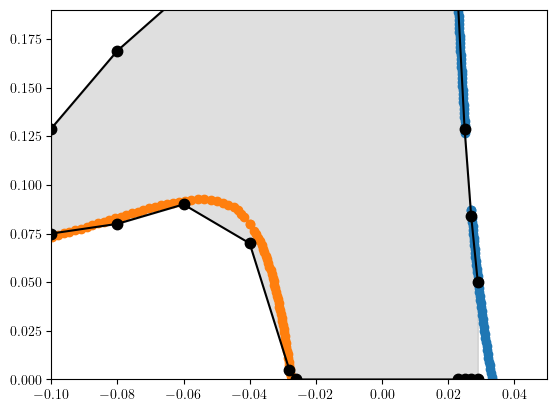

In [159]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

# split_idx = np.where(np.isnan(data[:,0]))[0][0]

# br1 = data[:split_idx]
# br2 = data[split_idx+1:]

# axs.plot(br1[:,0],br1[:,1],color='r',marker='.')
# axs.plot(br2[:,0],br2[:,1],color='r',marker='.')

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.1,.05)

In [160]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

In [161]:
# fig,axs = plt.subplots()
# axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
# axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
# axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)
# split_idx = np.where(np.isnan(data[:,0]))[0][0]

# br1 = data[:split_idx]
# br2 = data[split_idx+1:]

# axs.plot(br1[:,0],br1[:,1],color='r',marker='.')
# axs.plot(br2[:,0],br2[:,1],color='r',marker='.')

# axs.set_ylim(0,.15)
# axs.set_xlim(-.1,.05)

# Eigenvalue Convergence Plot

## Min

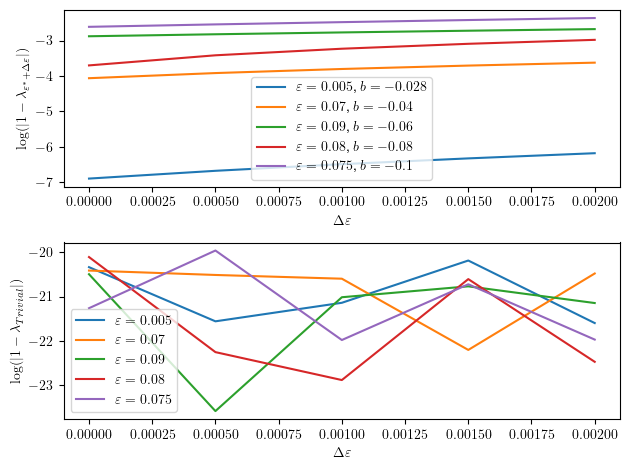

In [164]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

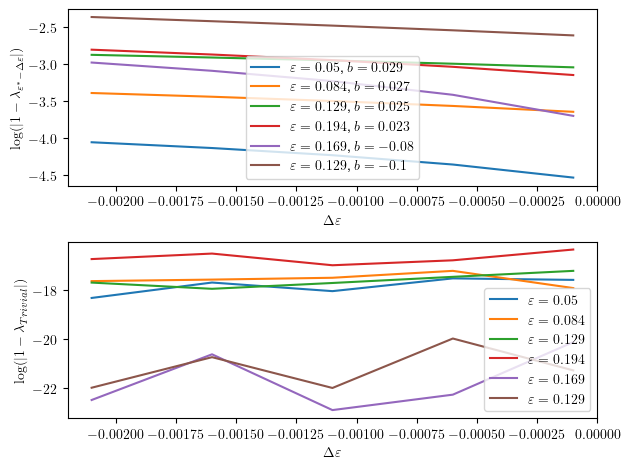

In [163]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))